# Introduction to Computer Vision: COVID-19 Image Classification

## Problem Statement

### Context

Covid-19 is a fast-growing disease that affects human health severly. Patients diagonised with this condition suffers from lung infection. The medical community has recently released vaccines which have a slower effect in increasing the immunity. This virus has impacted various countries' human health and financial standing.  <br>

Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.

### Objective

The aim of this project is to **build a Convolutional Neural Network to differentiate an X-ray image of a person affected with Covid from that of a healthy person or a person who has Viral Pneumonia(fever).**

### Data Dictionary

- This dataset contains training set images of 3 classes which are converted into numpy arrays.

- The dataset comprises 3 classes:
  - COVID-19: The patient who is effected due to covid.
  - Viral Pneumonia: This is a viral fever which has similar characteristics like fever and cough that of Covid but is not covid.
  - Normal- A healthy Person with no symptoms of covid or fever.

- The data file names are:
  - CovidImages.npy
  - CovidLabels.csv

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==2.0.3 opencv-python==4.8.0.76 -q --user

In [ ]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [ ]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importing matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization                     # Defining all the layers to build our NN Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D                 # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer                                                 # Importing One Hot Encoder
import sklearn.metrics as metrics                                                                # Importing metrics to evaluate accuracy, loss etc.
# Display images using OpenCV
#from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint                     # Different Model Tuning techniques
from sklearn.utils.class_weight import compute_class_weight                                       # Calculate class weights
from tensorflow.image import resize                                                               # For resizing images
from tensorflow.keras.regularizers import l2                                                      # For L2 Regularization
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/GL/covid_data/CovidImages.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/GL/covid_data/CovidLabels.csv')

### Utility Functions

In [ ]:
# Set Seaborn theme
sns.set_theme(style="ticks")

In [ ]:
# Function to input the images and labels to the function and plot the images with their labels
def plot_images(images,labels):
  num_classes=3                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(12, 10))                                              # Defining the figure size to 15x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

In [ ]:
# Function to plot loss/metrics
def plot(history, name):
    """
    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [ ]:
# function to visualize the images from Image Generator
def image_plot(generator, num_images):
    import matplotlib.pyplot as plt

    # Generate a batch of images and labels
    img_feature, img_label = next(generator)

    # Create a figure with a grid of subplots
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)  # Use 2 rows and 3 columns for the subplot grid
        plt.imshow(img_feature[i])
        label = np.argmax(img_label[i])  # Convert one-hot encoded vector to class label
        plt.title("Normal" if label == 0 else "Viral Pneumonia" if label == 1 else "Covid")
        plt.axis("off")
    plt.show()

In [ ]:
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
def plot_confusion_matrix(y_pred, y_true, class_names):
    """
    Plots a confusion matrix using the predicted and true labels.

    Parameters:
    - y_pred: array-like, shape (n_samples,) - Predicted labels
    - y_true: array-like, shape (n_samples,) - True labels
    - class_names: list of str - Names of the classes
    """
    # Compute the confusion matrix
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(
        confusion_mtx,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax,
        cmap='Blues'
    )

    # Setting the labels to both the axes
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Setting the tick labels
    ax.xaxis.set_ticklabels(class_names, rotation=20)
    ax.yaxis.set_ticklabels(class_names, rotation=20)

    # Show the plot
    plt.show()

In [ ]:
# Function to generate augmented data

# X_train: NumPy array of shape (num_samples, height, width, channels)
# y_train: NumPy array of shape (num_samples,)

def generate_data_augmented(X_train, y_train, batch_size):
    datagen = ImageDataGenerator(
        # rescale=1./255.,                  # Rescale pixel values to [0, 1]
        zoom_range=0.2,                     # Randomly rotates images by up to 20 degrees
        rotation_range=25,                  # Randomly shifts images horizontally by 10% of the total width
        width_shift_range=0.15,             # Randomly shifts images vertically by 10% of the total height
        height_shift_range=0.15,            # Randomly flips images horizontally
        horizontal_flip=True,
        fill_mode='nearest'
    )

    generator = datagen.flow(
        X_train,
        y_train,
        batch_size=batch_size,
        seed=42
    )

    return generator

**Using Callbacks in Keras**

Callbacks is hyperperameter that can be provided as “callbacks” argument to the model fit() function. Callbacks provide a way to execute code and interact with the training model process automatically.


Examples of Callbacks:

**ReduceLRonPlateau()** callback is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

**EarlyStopping()** callback is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. Early stopping is a regularization technique that stops training when a monitored metric stops improving. It's used in machine learning to prevent overfitting, which is when a model performs well on training data but can't generalize. Early stopping prevents the optimization process from converging in the expectation that predictions will be more accurate, but more biased.

**ModelCheckpoint** callback is a function in the Keras library that saves a model or its weights at a specific interval during training. The callback can save the model in two formats, "tf" and "h5", and can be used to save the best version of the model.



In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)

## Data Overview

### Understand the shape of the dataset

In [ ]:
print(images.shape)         # shape of images
print(labels.shape)         # shape of labels

## Exploratory Data Analysis

1. How are these different category X-ray images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

### Plotting random images from each of the class

In [ ]:
plot_images(images,labels)

### Distribution of Images (Labels)

In [ ]:
# Create the count plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Label', data=labels, palette='viridis')

# Add title and labels
plt.title('Distribution of Labels', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Display the plot
plt.show()

In [ ]:
labels.Label.value_counts()

Observation
- Above plot shows the dataset is imbalanced. 111 Covid, 70 Viral Pneumonia and 70 Normal images in dataset.

### Key Observations from EDA

- Dataset include 251 X-ray images along with their labels (Covid, Normal and Viral Pneumonia). X-ray images are provided in numpy array of int64 and corresponding labels of the images.
- Data has X-ray images of 111 Covid, 70 normal and 70 Viral Pneumonia patients.
- No missing values.
- There is a class imbalance in dataset since there are more Covid X-rays than Pneumonia or Healthy person's X-rays.
- The dataset has more Covid images compared to Viral Pneumonia and Normal. This imbalance can affect model training, potentially biasing the model towards the Covid class.
- COVID-19 X-ray: Look for hazy, ground-glass opacities that are often bilateral and peripheral. These may be patchy and not confined to a single lobe.
- Viral Pneumonia X-ray: Pneumonia is an infection that inflames the air sacs in one or both lungs. More likely to present with diffuse, bilateral ground-glass opacities and interstitial infiltrates. Consolidation, when present, tends to be patchy rather than lobar.
- As an engieer, it is very difficult to figure out visual difference between X-rays imaages of Covid vs. Normal vs. Viral Pneumonia patient.
- Visibibly, Covid X-ray images shows a lot of opacity. Normal X-ray images show darker shades compared to Covid. Pnuemonia X-rays shows some flud substance in small pockets.
- Dataset is small so we will need to use Data Augmentation type of approach to create more data to train the CNN Model.
- Dataset has 128x128 pixel images and all the images has 3 channels (RGB)
- The images appear to be grayscale and of consistent size.
- Data is already converted in to numpy array.
- Label dataset has only one column which tells target variable, what type of patient's X-ray image is.


## Data Pre-Processing

### Converting the BGR images to RGB images.

In [ ]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [ ]:
images_decreased=[]
height = 64
width =  64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

In [ ]:
plt.imshow(images[3])

**Image after resizing**

In [ ]:
plt.imshow(images_decreased[3])

**Observation**
- Images have degraded after resizing to 64x64
- We will use original size provided 128x128 for further analysis and training the model.
- After the training if model gives more or less same performance with reduced size of images then we can consider reducing of size images in final model.

### Data Preparation for Modeling

- Since we have small dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(np.array(images),labels, test_size=0.1, random_state=42, stratify=labels)

X_temp, X_test, y_temp, y_test = train_test_split(np.array(images),labels , test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

### Encoding the target labels

In [ ]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called LabelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()                               # Intialize the LabelBinarizer
y_train_encoded = enc.fit_transform(y_train)         # Fit and transform y_train
y_test_encoded=enc.transform(y_test)                 # Only transform y_test
y_val_encoded=enc.transform(y_val)

In [ ]:
y_train_encoded.shape, y_test_encoded.shape,y_val_encoded.shape

In [ ]:
# y_train_encoded

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [ ]:
# Normalize the image pixels of train, and test
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Model 1**
- Let's build a CNN model with 3 layers of Convolution & MaxPooling layers and then add full connected layers
- Add Dropout layers in hidden layers
- Use Adam as optimizer


In [ ]:
# Intializing a sequential model
model1 = Sequential()

# Add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
# Add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# Flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model1.add(Dense(256, activation='relu'))
# Add dropout with dropout_rate=0.5
model1.add(Dropout(0.5))

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))

# Add the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(3, activation='softmax'))

# Use the Adam Optimizer
opt=Adam(0.001)
# Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generates the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

In [ ]:
# type(y_train)

**Calculate weights to address imbalanced data**

In [ ]:
# Calculate class weights to addresss imbalanced data situation for training model
# unique_classes = np.unique(labels)
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y=y_train.values.reshape(-1))
class_weight_dict = dict(enumerate(class_weights)) # Pass the class weights to the model during training

In [ ]:
class_weight_dict

{0: 0.7565543071161048, 1: 1.2023809523809523, 2: 1.1812865497076024}

<b> Fitting the model on the train data

In [ ]:
# Fit the model on train data
history1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            # validation_split=0.1,
            validation_data=(X_val_normalized,y_val_encoded),
            # shuffle=False,
            batch_size=64,
            class_weight=class_weight_dict,
            verbose=1
          )

Epoch 1/30
4/4 [==============================] - 45s 9s/step - loss: 1.1288 - accuracy: 0.3020 - val_loss: 1.0978 - val_accuracy: 0.2609
Epoch 2/30
4/4 [==============================] - 25s 5s/step - loss: 1.0912 - accuracy: 0.3564 - val_loss: 1.0885 - val_accuracy: 0.2609
Epoch 3/30
4/4 [==============================] - 19s 5s/step - loss: 1.0873 - accuracy: 0.3416 - val_loss: 1.0596 - val_accuracy: 0.5217
Epoch 4/30
4/4 [==============================] - 19s 5s/step - loss: 1.0575 - accuracy: 0.4257 - val_loss: 1.0367 - val_accuracy: 0.6522
Epoch 5/30
4/4 [==============================] - 19s 4s/step - loss: 1.0110 - accuracy: 0.4604 - val_loss: 0.9523 - val_accuracy: 0.6957
Epoch 6/30
4/4 [==============================] - 21s 5s/step - loss: 0.9698 - accuracy: 0.4703 - val_loss: 0.8452 - val_accuracy: 0.7391
Epoch 7/30
4/4 [==============================] - 21s 5s/step - loss: 0.8578 - accuracy: 0.6188 - val_loss: 0.6370 - val_accuracy: 0.8696
Epoch 8/30
4/4 [==================

Observations:

- We can see from the above plot that **the training accuracy of the  model was good (96%) and the validation accuracy was was (91%).**
- The model has 2234595 trainable params. Model seems to be stable.
- There seems to be little of noise in data.
- Let's check the model performance on test set.





**Model Evaluation**

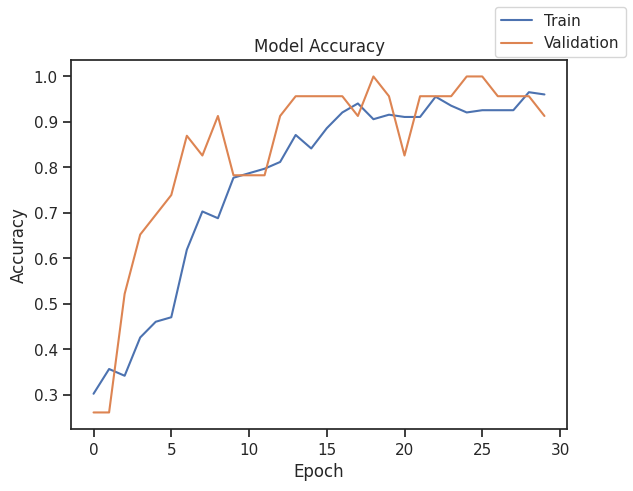

In [ ]:
plot(history1,'accuracy')

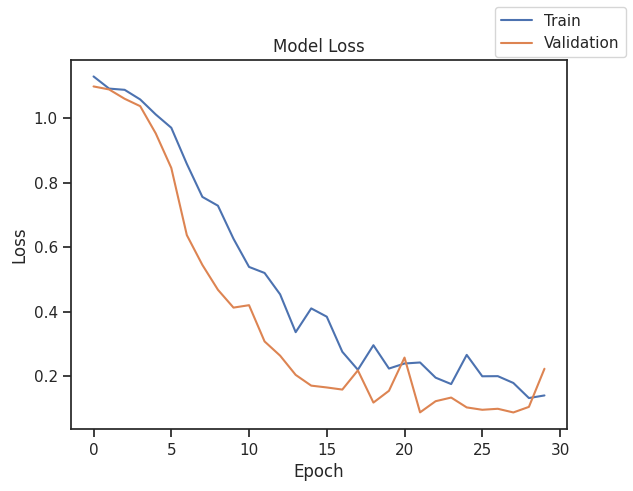

In [ ]:
plot(history1,'loss')

**Evaluate the model on test data**

In [ ]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    # Evaluate the model on test data

1/1 - 1s - loss: 0.1636 - accuracy: 0.9231 - 980ms/epoch - 980ms/step


**Plotting the Confusion Matrix**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)                          # Predict the output probabilities

# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

1/1 [==============================] - 1s 1s/step


In [ ]:
# list(enc.classes_)
y_test_encoded.shape

(26, 3)

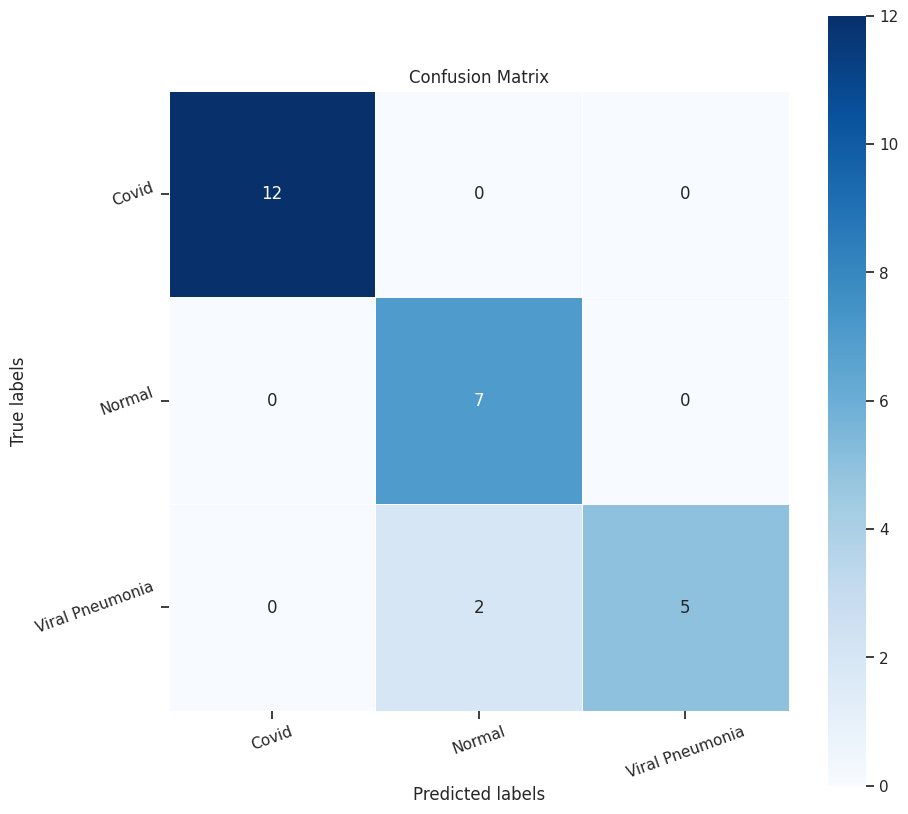

In [ ]:
# Assuming y_pred_classes and y_test_classes are the predicted and true labels, respectively
class_names = list(enc.classes_) # ['Covid', 'Normal', 'Viral Pneumonia']
plot_confusion_matrix(y_pred_arg, y_test_arg, class_names)

**Plotting Classification Report**

In [ ]:
# Plotting the classification report
cr1 = metrics.classification_report(y_test_arg,y_pred_arg)
print(cr1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.78      1.00      0.88         7
           2       1.00      0.71      0.83         7

    accuracy                           0.92        26
   macro avg       0.93      0.90      0.90        26
weighted avg       0.94      0.92      0.92        26



**Observations**
- Base model gave a very good performance with overall 92% accuracy on test data.
- Model seems generalized.
- Confusion Matrix shows it identified all Covid images correctly.

## Model Performance Improvement

### **Model 2**
#### **Data Augmentation**
- Since we have limited dataset, let's try to use use Data Augmentation to create more variety of data.
- Data Augmentation (DA) is a machine learning technique that artificially increases the size and diversity of a training set by making changes to existing data or generating new data points.

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Generate augmented training and validation data**

The **ImageDataGenerator** produces batches of real-time enhanced tensor image data.

In [ ]:
# Use ImageDataGenerator function to generate augmented images.
batch_size = 32
aug_train_data = generate_data_augmented(X_train_normalized, y_train_encoded, batch_size)

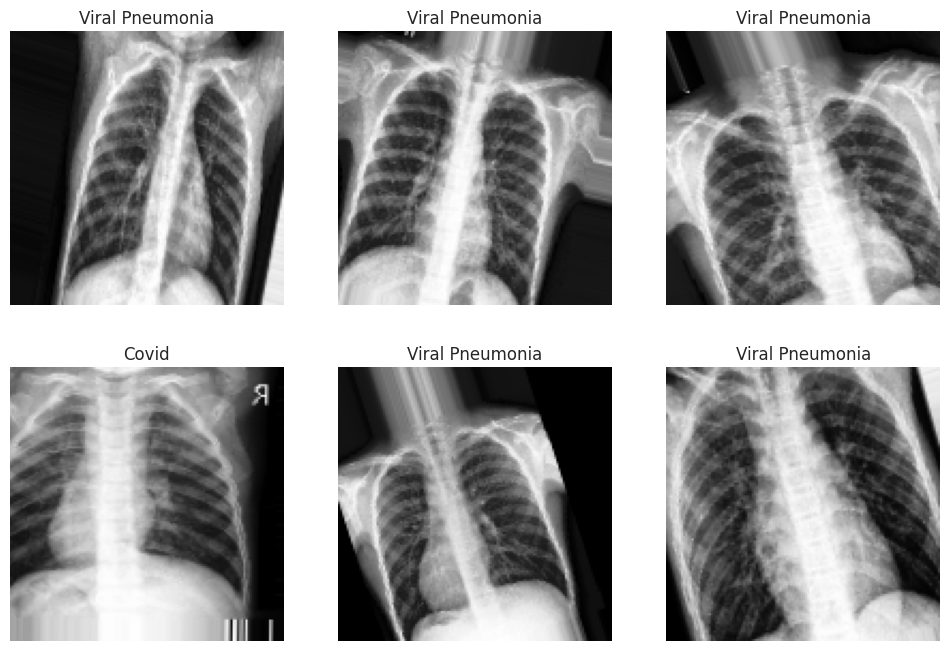

In [ ]:
image_plot(aug_train_data,6)

**Model Building**

In [ ]:
# Intializing a sequential model
model2 = Sequential()

# Add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(256, (3,3), activation='relu', padding="same", input_shape=(128, 128, 3)))

# Add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# Create two similar convolution and max-pooling layers activation = relu
model2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# model2.add(MaxPooling2D((2, 2), padding = 'same'))
# model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

l2_lambda = 0.001

# Adding a fully connected dense layer with 256 neurons
model2.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
# Add dropout with dropout_rate=0.5
model2.add(Dropout(0.5))
model2.add(BatchNormalization())

model2.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())

# model2.add(Dense(64, activation='relu'))
# model2.add(Dropout(0.5))
# model2.add(BatchNormalization())

# Add the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(3, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.001, momentum=0.9)

# Initialize Adam Optimimzer
opt=Adam(0.001)
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 256)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 256)       1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                        

**Model Evaluation**

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 32

# Define callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00001)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)   #stops the model training if there is no improvement in metrics
checkpoint = ModelCheckpoint('model/ai_model_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True) # defines file path to save the best model weights, define accuracy metric, verbose display updates of the model and saves best model

callbacks_list = [learning_rate_reduction]

# Fitting the model on train data
history2 = model2.fit(
    aug_train_data,
    epochs=epochs,
    validation_data=(X_val_normalized, y_val_encoded),
    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
    class_weight=class_weight_dict,
    callbacks=callbacks_list,
    batch_size = batch_size,
    shuffle=False,
    verbose=1
)

Epoch 1/30
6/6 [==============================] - 95s 16s/step - loss: 1.9708 - accuracy: 0.5781 - val_loss: 3.8019 - val_accuracy: 0.2609 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 61s 10s/step - loss: 2.3161 - accuracy: 0.5573 - val_loss: 3.0982 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - 69s 11s/step - loss: 2.4012 - accuracy: 0.5938 - val_loss: 2.5149 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - 70s 12s/step - loss: 2.4573 - accuracy: 0.6927 - val_loss: 2.7862 - val_accuracy: 0.4348 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - 57s 9s/step - loss: 2.4621 - accuracy: 0.7240 - val_loss: 3.9643 - val_accuracy: 0.4348 - lr: 0.0010
Epoch 6/30
6/6 [==============================] - ETA: 0s - loss: 2.4322 - accuracy: 0.7552
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
6/6 [==============================] - 57s 10s/step - loss: 2.4322 - acc

In [ ]:
plot(history2,'accuracy')

In [ ]:
plot(history2,'loss')

**Evaluate the model on test data**

In [ ]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

**Plotting the Confusion Matrix**

In [ ]:
# obtain the output probabilities
y_pred = model2.predict(X_test_normalized)

# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

In [ ]:
# Plot confusion matrix
class_names = ['Viral Pneumonia', 'Covid', 'Normal']
plot_confusion_matrix(y_pred_arg, y_test_arg, class_names)

**Plotting Classification Report**

In [ ]:
# Plotting the classification report
cr2 = metrics.classification_report(y_test_arg,y_pred_arg)
print(cr2)

**Observations**
- Model didnt perform good with augmented data. The model has 79% accuracy on training data but accuracy on validation and test data is 43 and 46% resp. Model is overfitting.
- Validation accuracy seems to be stuck at 0.4348. Tried different approaches like adding dropout, normalization, reducing learning but did not help.
- The validation loss is constant and not improving, it could indeed indicate that your model is not learning effectively, potentially due to fitting on noise or having insufficient or uninformative features. There are several strategies we could try like 1. Extensive amount of data augmentation, 2.Extracting More Informative Features, 3. Apply Regularization Techniques like L2 and try hyperparameter tuning.
- Model has 33925251 trainable params. It gave 80% accuracy on train data whereas accuracy on test was 46%.
- Model gave performance of overall 46%.

### **Model 3**
Let's use **VGG16** model with Transfer Learning.


In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Resize images**
- **VGG16** model is trained on 224x224 image size so we need to resize our images to utilize weights of VGG16 model

In [ ]:
# Resize images to 224x224
images_resized = np.array([resize(image, (224, 224)).numpy() for image in images])

**Split Data and Normalize Data**

In [ ]:
# Reload the dataset and split the data
X_temp_vgg16, X_test_vgg16, y_temp_vgg16, y_test_vgg16 = train_test_split(images_resized, labels, test_size=0.1, random_state=42, stratify=labels)
X_train_vgg16, X_val_vgg16, y_train_vgg16, y_val_vgg16 = train_test_split(X_temp_vgg16, y_temp_vgg16, test_size=0.1, random_state=42, stratify=y_temp_vgg16)

# Label encoding
enc = LabelBinarizer()
y_train_vgg16_encoded = enc.fit_transform(y_train_vgg16)
y_test_vgg16_encoded = enc.transform(y_test_vgg16)
y_val_vgg16_encoded = enc.transform(y_val_vgg16)

# Convert to float32 and normalize
X_train_vgg16_normalized = X_train_vgg16.astype('float32') / 255.0
X_val_vgg16_normalized = X_val_vgg16.astype('float32') / 255.0
X_test_vgg16_normalized = X_test_vgg16.astype('float32') / 255.0


**Model Building**

In [ ]:
# defining the VGG16 as base model
height = 224    # VGG16 model is training on 224x224 images
width = 224

# Defines the input shape for the model (height, width, number of channels)
input_shape = (height, width, 3)

# Loads the pre-trained weights of the VGG16 model trained on ImageNet dataset
vgg16_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,                          # Excludes the top (fully connected) layers of the VGG16 model
    input_shape=input_shape
)

# Free all layers and set it as not trainable
vgg16_model.trainable = False                   # Freezes the weights of the VGG16 model to prevent further training

In [ ]:
# Intializing a sequential model
model3 = Sequential()

# Adds the VGG16 base model to the sequential model
model3.add(vgg16_model)
model3.add(GlobalAveragePooling2D())                      # Adds a global average pooling layer

# Flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model3.add(Flatten())

# Add the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model3.add(Dense(3, activation='softmax'))

# opt = SGD(learning_rate=0.01, momentum=0.9)
# Use the Adam Optimizer
opt=Adam(0.001)
# Compile the model using suitable metric for loss fucntion
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generates the summary of the model
model3.summary()

In [ ]:
# class_weight_dict

In [ ]:
# Epochs
epochs = 30
# Batch size
batch_size = 32

# Define callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.2,min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #stops the model training if there is no improvement in metrics
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/ai_model_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True) # defines file path to save the best model weights, define accuracy metric, verbose display updates of the model and saves best model

callbacks_list = [checkpoint, early_stopping]

# fit the model on train data
history3 = model3.fit(
            X_train_vgg16_normalized, y_train_vgg16_encoded,
            epochs=epochs,
            # validation_split=0.1,
            validation_data=(X_val_vgg16_normalized, y_val_vgg16_encoded),
            shuffle=False,
            batch_size=batch_size,
            class_weight=class_weight_dict,
            # callbacks=callbacks_list,
            verbose=1
)

**Model Evaluation**

In [ ]:
plot(history3, "accuracy")

In [ ]:
plot(history3, "loss")

In [ ]:
# accuracy = model3.evaluate(X_val_vgg16_normalized, y_val_vgg16_encoded, verbose=2)

**Evaluate the model on test data**

In [ ]:
accuracy = model3.evaluate(X_test_vgg16_normalized, y_test_vgg16_encoded, verbose=2)

**Plotting the Confusion Matrix**

In [ ]:
# obtain the output probabilities
y_pred=model3.predict(X_test_vgg16_normalized)

# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_vgg16_encoded,axis=1)

In [ ]:
# Plot confusion matrix
class_names = ['Covid', 'Normal', 'Viral Pneumonia']
plot_confusion_matrix(y_pred_arg, y_test_arg, class_names)

**Plotting Classification Report**

In [ ]:
# Plotting the classification report
cr3 =metrics.classification_report(y_test_arg,y_pred_arg)     # plot the classification report
print(cr3)

**Observations**
- Base model gave a good performance with overall 88% accuracy on training data and performance on validation is 82.
- Confusion Matrix shows that model identified all Covid images correctly.
- This model is using VGG16 transfer learning so it has 14716227 non-trainable params and has 1539 Trainable params.

### **Model 4**
Let's add Data Augmentation and use **VGG16** model with Transfer Learning.


In [ ]:
# Clearing backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Data Augmentation**

In [ ]:
# Define the training and validation data generators
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator()

# Create training data generator
train_generator = train_datagen.flow(X_train_vgg16_normalized, y_train_vgg16_encoded, batch_size=32, shuffle=True)

# Create validation data generator
validation_generator = validation_datagen.flow(X_val_vgg16_normalized, y_val_vgg16_encoded, batch_size=32, shuffle=False)

# Create test data generator (no augmentation, only rescaling)
test_generator = validation_datagen.flow(X_test_vgg16_normalized, y_test_vgg16_encoded, batch_size=32, shuffle=False)


**Model Building**

In [ ]:
# # defining the VGG16 as base model
# height = 224    # VGG16 model is training on 224x224 images
# width = 224

# # Defines the input shape for the model (height, width, number of channels)
# input_shape = (height, width, 3)

# # Loads the pre-trained weights of the VGG16 model trained on ImageNet dataset
# vgg16_model = tf.keras.applications.vgg16.VGG16(
#     weights='imagenet',
#     include_top=False,                          # Excludes the top (fully connected) layers of the VGG16 model
#     input_shape=input_shape
# )

# # Free all layers and set it as not trainable
# vgg16_model.trainable = False                   # Freezes the weights of the VGG16 model to prevent further training


In [ ]:
# l2_lambda

In [ ]:
# Intializing a sequential model
model4 = Sequential()

# Adds the VGG16 base model to the sequential model
model4.add(vgg16_model)
model4.add(GlobalAveragePooling2D())                      # Adds a global average pooling layer

# Flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model4.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model4.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_lambda)))
# Add dropout with dropout_rate=0.5
model4.add(Dropout(0.5))
model4.add(BatchNormalization())

# model4.add(Dense(256, activation='relu'))
# model4.add(Dropout(0.3))
# model4.add(BatchNormalization())


# Add the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model4.add(Dense(3, activation='softmax'))

# Use the Adam Optimizer
opt=Adam(0.0001)
# Compile the model using suitable metric for loss fucntion
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generates the summary of the model
model4.summary()

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Epochs
epochs = 30
# Batch size
batch_size = 32

# Define callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.2,min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #stops the model training if there is no improvement in metrics
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/ai_model_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True) # defines file path to save the best model weights, define accuracy metric, verbose display updates of the model and saves best model

callbacks_list = [learning_rate_reduction,checkpoint,early_stopping]

# Train the model
history4 = model4.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    batch_size = batch_size
    # callbacks=callbacks_list
)

**Model Evaluation**

In [ ]:
plot(history4, "accuracy")

In [ ]:
plot(history4, "loss")

**Evaluate the model on test data**

In [ ]:
accuracy = model4.evaluate(test_generator, verbose=2)  # evaluate the model on test data

**Plotting the Confusion Matrix**

In [ ]:
# obtain the output probabilities
y_pred=model4.predict(test_generator)

# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

In [ ]:
# Plot confusion matrix
class_names = ['Covid', 'Normal', 'Viral Pneumonia']
plot_confusion_matrix(y_pred_arg, y_test_arg, class_names)

**Plotting Classification Report**

In [ ]:
# Plotting the classification report
cr4 = metrics.classification_report(y_test_arg,y_pred_arg)     # plot the classification report
print(cr4)

**Observations**
- This model performed with 72% accuracy on train data whereas it gave 78% and 88% accuracy on validation and test data.
- This model does not seem stable.

## Model Performance Comparison and Final Model Selection

In [ ]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','CNN Model with VGG16 Transfer Learning','CNN Model with VGG16 and Data Augmentation' ],'Train Accuracy':['96%','80%','88%','71%'],'Validation Accuracy':['91%','43%','82%','78%'],'Test Accuracy':['92%','46%','96%','88%']})

- Best model seems to be Model 1 (Base CNN Model without Data Augmentation). It provided ~92% F1 Score on test data and looks generalized.
- Second best model is CNN Model with VGG16 Transfer Learning.
- Our final model will be Best performing model (Base CNN Model).

## Final Model

### Confusion Matrix for Final Model

In [ ]:
# Predict the output probabilities
y_pred=model1.predict(X_test_normalized)

# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)
plot_confusion_matrix(y_pred_arg, y_test_arg, class_names)

**It identified all Covid images from test data set. 2 out of 7 images of Viral Pneumonia were misclassfied as normal.**

### Visualizing the prediction

In [ ]:
# Reloading data with original 128x128 image
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images),labels , test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model1.predict((X_test[2].reshape(1,128,128,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[11])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model1.predict((X_test[11].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[11])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[18],)
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model1.predict((X_test[18].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[18])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[25])
plt.show()
## predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model1.predict((X_test[25].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[25])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

- Based on EDA and trying different models, it is obvious that we need more real data to train our AI model because augmented data didnt help much as expected.
- We can observe that Base CNN model gave better result overall since it extracted the featuers in images using CNN from scratch.
- Based on the accuracy of our AI models, it can help in diagnosis quickly and the hospital can leverage the model for operational efficiency.
- This can assist Radiologists by providing a second opinion on X-ray images, especially in detecting Covid cases.
- Hospitals and Medical facilities can implement a triage system where this AI model can help prioritize the cases with high probability of Covid, ensuring timely intervention.
- However there seems to be a little noise in data potentially making some impact on performance of any model so we need to monitor constantly and recommend to re-evaluate and re-train model periodically and/or when more data is available to train the AI Model.
- Continuously monitor the model's performance in real-world settings and update it with new data to maintain its accuracy and reliability.
- Data Augmentation was not helpful in improving the overall model performance so recommendation to business is get more data in general, especially more data unrepresented class images e.g. Viral Pneumonia.
- Since we do not have enough data, set thresholds for the acceptable lower limit of model performance and decide when to retrain the model.

_____

In [ ]:
# !pip install nbconvert  # Install nbconvert library to create html file

In [ ]:
# To convert notebook in to html file run following code. It will save html file in same location as notebook
# !jupyter nbconvert --to html '/content/drive/MyDrive/GL/RahulGanbote_Full_Code_COVID_19_Image_Classification.ipynb'